In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer
from utils import tuple_L1Loss, tuple_L2Loss, thresh_attrs
from pytorch_wavelets import DTCWTForward, DTCWTInverse, DWTForward, DWTInverse
import pywt

## load data and model

In [4]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## interp score & optimize wavelet

In [11]:
print(wt(im)[0].shape)
print(wt(im)[1].shape)
print(wt(im)[2].shape)
print(wt(im)[3].shape)

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 6, 128, 128, 2])
torch.Size([64, 1, 6, 64, 64, 2])
torch.Size([64, 1, 6, 32, 32, 2])


In [5]:
# input
torch.manual_seed(p.seed)
im = iter(train_loader).next()[0][0:64].to(device)
im.requires_grad = True

# wavelet transform with initialization
wt = Wavelet_Transform(J=3)
# initialization
eps = 0.05
wt.xfm.h0o.data = wt.xfm.h0o.data + eps*torch.randn(wt.xfm.h0o.data.shape).to(device)
wt.xfm.h1o.data = wt.xfm.h1o.data + eps*torch.randn(wt.xfm.h1o.data.shape).to(device)
wt.xfm.h0a.data = wt.xfm.h0a.data + eps*torch.randn(wt.xfm.h0a.data.shape).to(device)
wt.xfm.h1a.data = wt.xfm.h1a.data + eps*torch.randn(wt.xfm.h1a.data.shape).to(device)
wt.xfm.h0b.data = wt.xfm.h0b.data + eps*torch.randn(wt.xfm.h0b.data.shape).to(device)
wt.xfm.h1b.data = wt.xfm.h1b.data + eps*torch.randn(wt.xfm.h1b.data.shape).to(device)
wt.ifm.g0o.data = wt.ifm.g0o.data + eps*torch.randn(wt.ifm.g0o.data.shape).to(device)
wt.ifm.g1o.data = wt.ifm.g1o.data + eps*torch.randn(wt.ifm.g1o.data.shape).to(device)
wt.ifm.g0a.data = wt.ifm.g0a.data + eps*torch.randn(wt.ifm.g0a.data.shape).to(device)
wt.ifm.g1a.data = wt.ifm.g1a.data + eps*torch.randn(wt.ifm.g1a.data.shape).to(device)
wt.ifm.g0b.data = wt.ifm.g0b.data + eps*torch.randn(wt.ifm.g0b.data.shape).to(device)
wt.ifm.g1b.data = wt.ifm.g1b.data + eps*torch.randn(wt.ifm.g1b.data.shape).to(device)

# prepend transformation onto network
mt = TrimModel(model, wt.inverse)

# attributer
attr_methods = 'InputXGradient'
attributer = Attributer(mt, attr_methods=attr_methods)

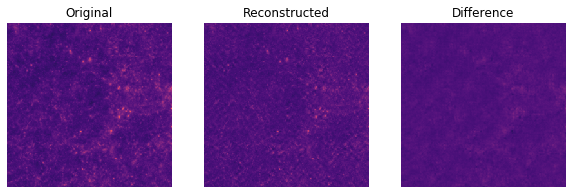

In [6]:
viz_im_r(im[0], wt.inverse(wt(im))[0])

In [30]:
# optimization params
losses = []
num_epochs = 1000
lamb = 0.1
sp_level = 10000

params = list(wt.xfm.parameters()) + list(wt.ifm.parameters())
optimizer = torch.optim.SGD(params, lr=0.000005)

# Training Loop
# Lists to keep track of progress
init_losses = [torch.norm(wt.inverse(wt(im)) - im)**2, tuple_L1Loss(thresh_attrs(attributer(wt(im), target=1), sp_level))]
print("Initial Loss: Recon={:.3f} and L1loss={:.3f}".format(init_losses[0], init_losses[1]))
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # zero grad
    optimizer.zero_grad()    
    # loss
    im_t = wt(im)
    reconstruction = wt.inverse(im_t)
    attributions = attributer(im_t, target=1)
    attributions_th = thresh_attrs(attributions, sp_level)
    loss1 = lamb*torch.norm(im - reconstruction)**2
    loss2 = -tuple_L1Loss(attributions_th)
    loss = loss1 + loss2
    # backward
    loss.backward()
    # Update step
    optimizer.step()
    
    losses.append(loss.data.item())
    print('\rIteration: {}/{}  Recon={:.3f}  L1loss={:.3f}'.format(epoch+1, num_epochs, loss1.item(), loss2.item()), end='')
    

Initial Loss: Recon=198.995 and L1loss=22.487
Starting Training Loop...
Iteration: 1000/1000  Recon=2.504  L1loss=-85.642

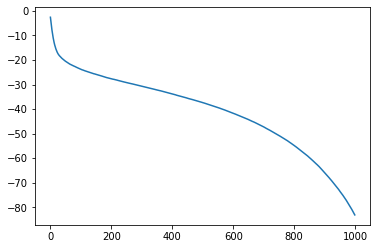

In [31]:
plt.plot(losses)

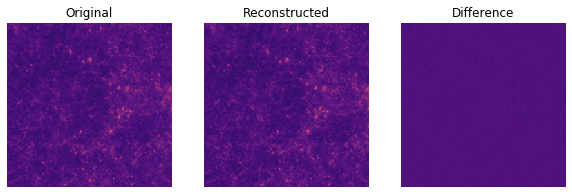

In [32]:
viz_im_r(im[0], wt.inverse(wt(im))[0])

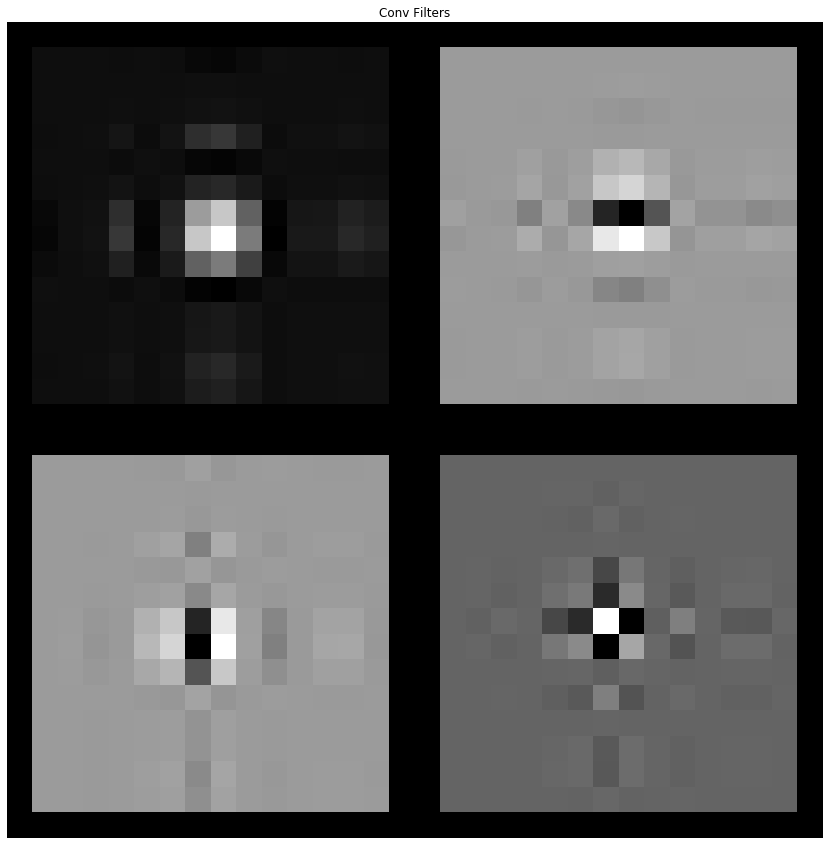

In [39]:
filters = torch.stack([wt.xfm.h0a.data.squeeze().unsqueeze(0)*wt.xfm.h0a.data.squeeze().unsqueeze(1),
                       wt.xfm.h0a.data.squeeze().unsqueeze(0)*wt.xfm.h1a.data.squeeze().unsqueeze(1),
                       wt.xfm.h1a.data.squeeze().unsqueeze(0)*wt.xfm.h0a.data.squeeze().unsqueeze(1),
                       wt.xfm.h1a.data.squeeze().unsqueeze(0)*wt.xfm.h1a.data.squeeze().unsqueeze(1)], dim=0)  
viz_filters(filters, n_row=2, n_col=2, resize_fac=1, normalize=True, title='Conv Filters')

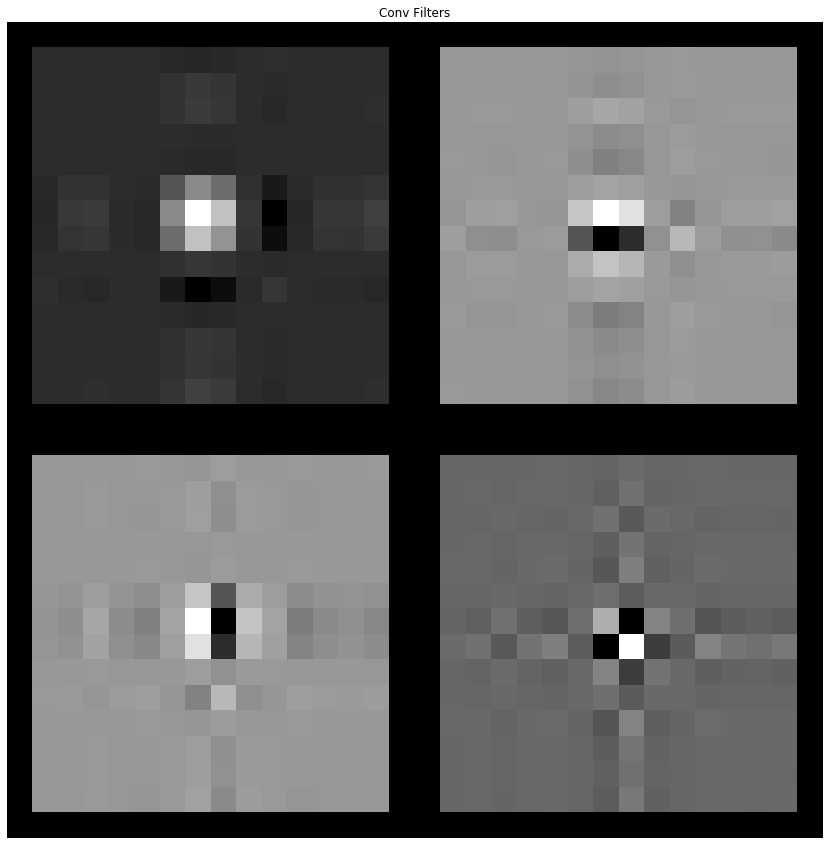

In [40]:
filters = torch.stack([wt.xfm.h0b.data.squeeze().unsqueeze(0)*wt.xfm.h0b.data.squeeze().unsqueeze(1),
                       wt.xfm.h0b.data.squeeze().unsqueeze(0)*wt.xfm.h1b.data.squeeze().unsqueeze(1),
                       wt.xfm.h1b.data.squeeze().unsqueeze(0)*wt.xfm.h0b.data.squeeze().unsqueeze(1),
                       wt.xfm.h1b.data.squeeze().unsqueeze(0)*wt.xfm.h1b.data.squeeze().unsqueeze(1)], dim=0)  
viz_filters(filters, n_row=2, n_col=2, resize_fac=1, normalize=True, title='Conv Filters')